## Downstream Task: ImageWang

[ImageWang](https://github.com/fastai/imagenette/blob/master/README.md) has a validation set that contains ten different dog breed types.

Let's try using this classification task as our downstream task.

In [125]:
import torch
from torch.nn import CrossEntropyLoss
from torchvision.models import resnet34

from pathlib import Path

from fastai2.metrics import accuracy
from fastai2.basics import DataBlock, RandomSplitter

from fastai2.data.block import CategoryBlock
from fastai2.data.transforms import Normalize, RegexLabeller
from fastai2.data.external import URLs, untar_data

from fastai2.vision.data import ImageDataBunch
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import cnn_learner, cnn_config, model_meta, _default_meta
from fastai2.vision.all import ImageBlock, get_image_files, imagenet_stats

In [37]:
imagewang_path = untar_data(URLs.IMAGEWANG_160)
imagewang_path

Path('/home/josh/.fastai/data/imagewang-160')

In [86]:
def get_parent_directory_as_label(raw_path):
    path = Path(raw_path)
    return path.parent.name

In [87]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=get_parent_directory_as_label)                

In [93]:
databunch = data.databunch(imagewang_path/'val', 
                        item_tfms=RandomResizedCrop(160, min_scale=0.75),
                        bs=16,
                        batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])

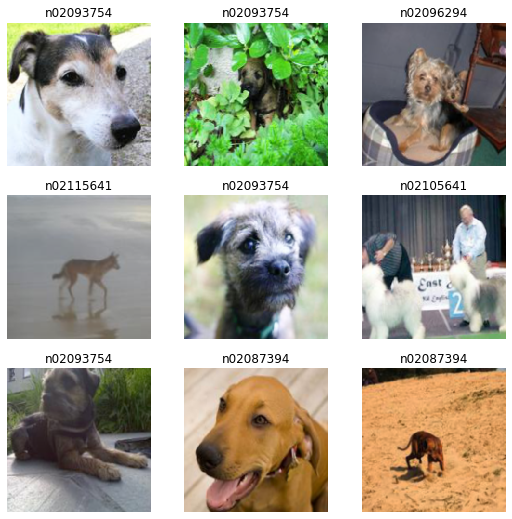

In [99]:
databunch.show_batch(max_n=9)

In [106]:
x,y = databunch.train_dl.one_batch()

In [107]:
x.shape

torch.Size([16, 3, 299, 299])

In [108]:
y.shape

torch.Size([16])

In [112]:
y

tensor([5, 4, 3, 0, 9, 7, 5, 0, 1, 1, 8, 2, 4, 0, 3, 7], device='cuda:0')

In [110]:
output = learn.model(x)

In [111]:
output.shape

torch.Size([16, 10])

## Run with random weights

Simply create a ResNet-34 with random weights and train it for 15 epochs.

In [144]:
loss = CrossEntropyLoss()
learn = cnn_learner(databunch, resnet34, pretrained=False, config=cnn_config(), loss_func=loss, metrics=[accuracy])

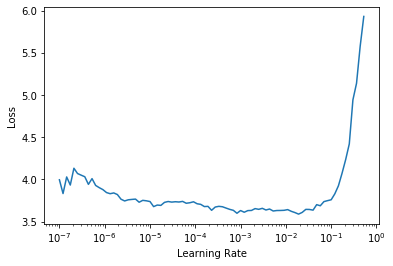

In [146]:
learn.freeze()
learn.lr_find()

In [147]:
learn.fit_one_cycle(5, slice(10e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.086266,4.151276,0.114650,00:18
1,6.450535,6.230371,0.109554,00:18
2,3.881202,16.876389,0.154140,00:18
3,2.602939,23.430473,0.182166,00:18
4,2.264725,6.172953,0.203822,00:18


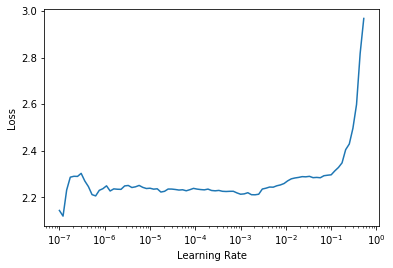

In [148]:
learn.unfreeze()
learn.lr_find()

In [149]:
# Fine tune on this task
learn.fit_one_cycle(10, slice(10e-4, 10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.274984,237.790649,0.143949,00:22
1,2.333948,2.287210,0.103185,00:23
2,2.234458,13.085814,0.143949,00:23
3,2.331129,3.925131,0.140127,00:23
4,2.252745,7.091119,0.132484,00:23
5,2.219536,7.094331,0.198726,00:23
6,2.135952,2.093225,0.203822,00:23
7,2.092707,2.057637,0.234395,00:23
8,2.023619,1.992290,0.239490,00:23
9,2.006235,1.979191,0.249682,00:23


## Run with pretext weights

For this experiment we run using the weights generated by pretraining our network on a pretext task. We're hoping that by pretraining a neural network on a pretext task, we get weights that are in a better position to learn this downstream classification task (as compared to random weights).

In [129]:
loss = CrossEntropyLoss()
learn = cnn_learner(databunch, resnet34, pretrained=False, config=cnn_config(), loss_func=loss, metrics=[accuracy])

In [130]:
# Load backbone from saved model
# NOTE: This step depends on running all cells from 02_ImagePatches_ImageWang.ipynb
state_dict = torch.load('pascal_15_epoch.pth')
learn.model[0].load_state_dict(state_dict)
learn.freeze()

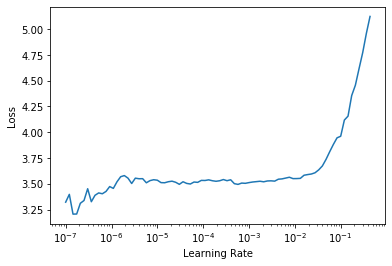

In [131]:
learn.lr_find()

In [132]:
learn.fit_one_cycle(5, slice(10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.287449,3.253466,0.127389,00:16
1,2.958001,2.730592,0.122293,00:17
2,2.658242,2.361057,0.157962,00:17
3,2.427255,2.287079,0.193631,00:17
4,2.309800,2.173093,0.205096,00:17


In [ ]:
learn.unfreeze()
learn.lr_find()

In [133]:
learn.fit_one_cycle(10, slice(10e-4, 10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.301041,2.101185,0.214013,00:22
1,2.411435,2.360674,0.169427,00:23
2,2.255489,2.326856,0.157962,00:23
3,2.150144,2.276299,0.194904,00:22
4,2.080085,1.993220,0.247134,00:22
5,1.986100,1.930611,0.280255,00:22
6,1.874988,1.774678,0.343949,00:22
7,1.806772,1.688903,0.360510,00:22
8,1.723014,1.649664,0.379618,00:22
9,1.678803,1.635251,0.392357,00:22


## Run with ImageNet Weights

For this experiment we run using the weights generated by pretraining our network on ImageNet. 

In [137]:
loss = CrossEntropyLoss()
learn = cnn_learner(databunch, resnet34, pretrained=True, config=cnn_config(), loss_func=loss, metrics=[accuracy])

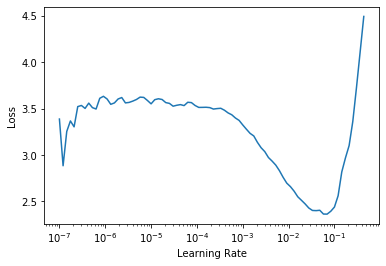

In [138]:
learn.lr_find()

In [139]:
# Fine tune on this task
learn.fit_one_cycle(5, lr_max=10e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.331456,10.617470,0.101911,00:15
1,4.771839,4.759386,0.145223,00:16
2,3.069615,2.822441,0.189809,00:17
3,2.380256,2.215498,0.217834,00:17
4,2.056978,1.948544,0.319745,00:17


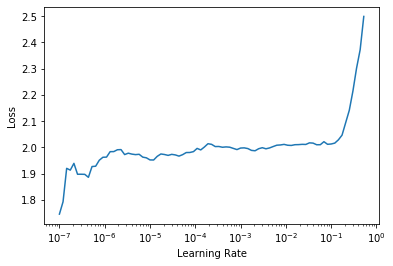

In [140]:
learn.lr_find()

In [141]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(10e-4, 10e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.096447,87.447083,0.121019,00:22
1,2.190989,2.600005,0.165605,00:22
2,2.115496,4.348145,0.229299,00:22
3,2.073757,15.071845,0.235669,00:22
4,2.014063,14.357773,0.298089,00:23
5,1.892217,4.347929,0.301911,00:23
6,1.841710,1.934102,0.323567,00:23
7,1.765970,1.973020,0.393631,00:23
8,1.689572,1.604584,0.428025,00:23
9,1.669283,1.594876,0.438217,00:23


So it looks like we get

- ~25% accuracy when using random weights
- ~39% accuracy when using pretext weights
- ~44% accuracy when using ImageNet weights